In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
chosen_random_state = 42

In [3]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from scipy.stats import uniform
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers, optimizers
from keras.utils import np_utils
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_importance

np.random.seed(chosen_random_state)

Tobi's labels have been mapped to integer values: 

'active_products' : 1

'commercial_offers' : 2

'current_balance' : 3

'spend_management' : 4

In [4]:
frequency_threshold = 5000

## Data import

- _df_train_ represents the dataset containing the training set labels
- _df_predict_ has not been imported yet, but it will be the list of '_session_id_' on which we will make predictions
- _df_ represents the entire dataset, joined with _df_train_ to include the labels

In [5]:
original_df = pq.read_table('/content/drive/My Drive/Vodafone Hackaton/full_dataset.parquet').to_pandas()

In [6]:
original_df.head()

,session_id,user_identifier,event_timestamp,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,tobi_timestamp
0,182576,0,2020-09-22 14:38:14,1_5,2,None,None,2020-09-24 02:03:53
1,182576,0,2020-09-22 14:38:14,1_4,2_9,3_5,None,2020-09-24 02:03:53
2,182576,0,2020-09-22 11:46:56,1_4,2_9,3_6,None,2020-09-24 02:03:53
3,182576,0,2020-09-22 11:23:50,1_4,2_9,3_12,None,2020-09-24 02:03:53
4,182576,0,2020-09-22 11:21:29,1_4,2_9,3_6,None,2020-09-24 02:03:53


In [7]:
df_train = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/train.csv')

In [8]:
df_train.head()

,label,session_id
0,2,6
1,1,13
2,2,21
3,2,22
4,4,32


In [9]:
df_predict = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')

In [10]:
original_df = original_df.join(df_train.set_index('session_id'), on='session_id')

In [11]:
original_df.fillna(value={'event_category_idx_lv2':'Not_applicable_lv2','event_category_idx_lv3':'Not_applicable_lv3','event_category_idx_lv4':'Not_applicable_lv4','label':0}, inplace=True)

In [12]:
original_df.head()

,session_id,user_identifier,event_timestamp,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,tobi_timestamp,label
0,182576,0,2020-09-22 14:38:14,1_5,2,Not_applicable_lv3,Not_applicable_lv4,2020-09-24 02:03:53,1.0
1,182576,0,2020-09-22 14:38:14,1_4,2_9,3_5,Not_applicable_lv4,2020-09-24 02:03:53,1.0
2,182576,0,2020-09-22 11:46:56,1_4,2_9,3_6,Not_applicable_lv4,2020-09-24 02:03:53,1.0
3,182576,0,2020-09-22 11:23:50,1_4,2_9,3_12,Not_applicable_lv4,2020-09-24 02:03:53,1.0
4,182576,0,2020-09-22 11:21:29,1_4,2_9,3_6,Not_applicable_lv4,2020-09-24 02:03:53,1.0


In [13]:
df = original_df.copy()

## Data exploration and pre-processing



_labelled_df_ rappresenta la parte del dataset _df_ già etichettata, _predict_df_ DOVREBBE rappresentare la parte di dataset contenente le sessions da predire.

Tutti i '_NaN_' per il secondo, il terzo ed il quarto evento vengono sostituiti da '_Not_applicable_'.\
Si potrebbe ulteriormente valutare una discriminazione; e.g.: _Not_applicable_lv2_, _Not_applicable_lv3_, _Not_applicable_lv4_

Empiricamente, abbiamo identificato una sessione senza l'evento fittizio avente '1_5' nella categoria lv_1

In [14]:
df[df['session_id']==1606226]

,session_id,user_identifier,event_timestamp,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,tobi_timestamp,label
1431141,1606226,25526,2020-06-04 13:24:00,1_1,2_0,3_0,4_1,2020-06-05 17:55:04,1.0


Ogni sessione dovrebbe avere un evento fittizio caratterizzato da '1_5' nella categoria lv_1, ma ciò non avviene per 45 sessioni su 208,486. Dato il numero esiguo, per il momento queste sessioni verranno scartate.

In [15]:
df['days_after_event'] = (df['tobi_timestamp'] - df['event_timestamp']).apply(lambda x: (1 + x.days))

In [16]:
idx_max_delta_days = df.groupby('session_id')['days_after_event'].idxmax().to_frame().rename(columns={'days_after_event':'idx_max_days_after_event'})
idx_max_delta_days = idx_max_delta_days.join(df['days_after_event'], on='idx_max_days_after_event', how='inner').rename(columns={'days_after_event':'days_after_first_event'})

idx_max_delta_days.head()

,idx_max_days_after_event,days_after_first_event
session_id,,
6,4134595,9
13,1041399,16
21,3201582,51
22,4167280,32
23,1314528,64


In [17]:
idx_min_delta_days = df.groupby('session_id')['days_after_event'].idxmin().to_frame().rename(columns={'days_after_event':'idx_min_days_after_event'})
idx_min_delta_days = idx_min_delta_days.join(df['days_after_event'], on='idx_min_days_after_event', how='inner').rename(columns={'days_after_event':'days_after_last_event'})

In [18]:
values = df[df['event_category_idx_lv1']!='1_5']['session_id'].value_counts().to_frame().reset_index().rename(columns={'index':'session_id', 'session_id':'# of events'})
values = values.join(idx_max_delta_days.drop(columns=['idx_max_days_after_event']), on='session_id', how='inner')
values = values.join(idx_min_delta_days.drop(columns=['idx_min_days_after_event']), on='session_id', how='inner')

values.head()

,session_id,# of events,days_after_first_event,days_after_last_event
0,12282,30,59,2
1,190793,30,30,1
2,14611,30,35,24
3,26905,30,59,2
4,31003,30,62,3


In [19]:
len(values)

347837

In [20]:
df = df.join(values.set_index('session_id'), on='session_id')
df = df.drop(columns=['days_after_event'])

In [21]:
df = df[df['event_category_idx_lv1']!='1_5']

df.head()

,session_id,user_identifier,event_timestamp,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event
1,182576,0,2020-09-22 14:38:14,1_4,2_9,3_5,Not_applicable_lv4,2020-09-24 02:03:53,1.0,30,63,2
2,182576,0,2020-09-22 11:46:56,1_4,2_9,3_6,Not_applicable_lv4,2020-09-24 02:03:53,1.0,30,63,2
3,182576,0,2020-09-22 11:23:50,1_4,2_9,3_12,Not_applicable_lv4,2020-09-24 02:03:53,1.0,30,63,2
4,182576,0,2020-09-22 11:21:29,1_4,2_9,3_6,Not_applicable_lv4,2020-09-24 02:03:53,1.0,30,63,2
5,182576,0,2020-09-22 10:58:23,1_4,2_9,3_12,Not_applicable_lv4,2020-09-24 02:03:53,1.0,30,63,2


## Grouping of less frequent categories

In [22]:
freq_lv1 = df[df['label']!=0]['event_category_idx_lv1'].value_counts().to_frame().reset_index().rename(columns={'index':'event_lv1', 'event_category_idx_lv1':'# of occurrencies'})
freq_lv2 = df[df['label']!=0]['event_category_idx_lv2'].value_counts().to_frame().reset_index().rename(columns={'index':'event_lv2', 'event_category_idx_lv2':'# of occurrencies'})
freq_lv3 = df[df['label']!=0]['event_category_idx_lv3'].value_counts().to_frame().reset_index().rename(columns={'index':'event_lv3', 'event_category_idx_lv3':'# of occurrencies'})
freq_lv4 = df[df['label']!=0]['event_category_idx_lv4'].value_counts().to_frame().reset_index().rename(columns={'index':'event_lv4', 'event_category_idx_lv4':'# of occurrencies'})

In [23]:
relevant_event_lv1 = freq_lv1[freq_lv1['# of occurrencies']>frequency_threshold]['event_lv1'].tolist()
relevant_event_lv2 = freq_lv2[freq_lv2['# of occurrencies']>frequency_threshold]['event_lv2'].tolist()
relevant_event_lv3 = freq_lv3[freq_lv3['# of occurrencies']>frequency_threshold]['event_lv3'].tolist()
relevant_event_lv4 = freq_lv4[freq_lv4['# of occurrencies']>frequency_threshold]['event_lv4'].tolist()

for i in freq_lv1.index.to_list():
  if freq_lv1.loc[i, 'event_lv1'] not in relevant_event_lv1:
    freq_lv1.loc[i, 'event_category_idx_lv1_updated'] = 'other_lv1'
  else:
    freq_lv1.loc[i, 'event_category_idx_lv1_updated'] = freq_lv1.loc[i, 'event_lv1']

for i in freq_lv2.index.to_list():
  if freq_lv2.loc[i, 'event_lv2'] not in relevant_event_lv2:
    freq_lv2.loc[i, 'event_category_idx_lv2_updated'] = 'other_lv2'
  else:
    freq_lv2.loc[i, 'event_category_idx_lv2_updated'] = freq_lv2.loc[i, 'event_lv2']

for i in freq_lv3.index.to_list():
  if freq_lv3.loc[i, 'event_lv3'] not in relevant_event_lv3:
    freq_lv3.loc[i, 'event_category_idx_lv3_updated'] = 'other_lv3'
  else:
    freq_lv3.loc[i, 'event_category_idx_lv3_updated'] = freq_lv3.loc[i, 'event_lv3']

for i in freq_lv4.index.to_list():
  if freq_lv4.loc[i, 'event_lv4'] not in relevant_event_lv4:
    freq_lv4.loc[i, 'event_category_idx_lv4_updated'] = 'other_lv4'
  else:
    freq_lv4.loc[i, 'event_category_idx_lv4_updated'] = freq_lv4.loc[i, 'event_lv4']

In [24]:
df = df.join(freq_lv1.set_index('event_lv1'), on='event_category_idx_lv1').drop(columns=['event_category_idx_lv1', '# of occurrencies']).rename(columns={'event_category_idx_lv1_updated':'event_category_idx_lv1'})
df = df.join(freq_lv2.set_index('event_lv2'), on='event_category_idx_lv2').drop(columns=['event_category_idx_lv2', '# of occurrencies']).rename(columns={'event_category_idx_lv2_updated':'event_category_idx_lv2'})
df = df.join(freq_lv3.set_index('event_lv3'), on='event_category_idx_lv3').drop(columns=['event_category_idx_lv3', '# of occurrencies']).rename(columns={'event_category_idx_lv3_updated':'event_category_idx_lv3'})
df = df.join(freq_lv4.set_index('event_lv4'), on='event_category_idx_lv4').drop(columns=['event_category_idx_lv4', '# of occurrencies']).rename(columns={'event_category_idx_lv4_updated':'event_category_idx_lv4'})

In [25]:
df

,session_id,user_identifier,event_timestamp,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4
1,182576,0,2020-09-22 14:38:14,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_5,Not_applicable_lv4
2,182576,0,2020-09-22 11:46:56,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4
3,182576,0,2020-09-22 11:23:50,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4
4,182576,0,2020-09-22 11:21:29,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4
5,182576,0,2020-09-22 10:58:23,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4
...,...,...,...,...,...,...,...,...,...,...,...,...
5676984,1549128,871095,2020-06-01 17:22:28,2020-06-02 16:26:54,4.0,1,1,1,1_4,2_9,3_13,Not_applicable_lv4
5676986,1590753,871099,2020-06-01 00:00:00,2020-06-03 14:50:18,0.0,1,3,3,1_2,2_1,3_2,Not_applicable_lv4
5676988,1559831,871110,2020-06-01 00:00:00,2020-06-17 10:39:45,3.0,1,17,17,1_2,2_14,3_4,Not_applicable_lv4
5676990,1586623,871111,2020-06-05 17:51:07,2020-06-08 19:44:24,0.0,1,4,4,1_8,Not_applicable_lv2,Not_applicable_lv3,Not_applicable_lv4


## Experiment with event concatenation

In [26]:
df['concat_cat'] = df.event_category_idx_lv1 + '_' + df.event_category_idx_lv2 + '_' + df.event_category_idx_lv3 + '_' + df.event_category_idx_lv4

In [27]:
df.head()

,session_id,user_identifier,event_timestamp,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,concat_cat
1,182576,0,2020-09-22 14:38:14,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_5,Not_applicable_lv4,1_4_2_9_3_5_Not_applicable_lv4
2,182576,0,2020-09-22 11:46:56,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4
3,182576,0,2020-09-22 11:23:50,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4
4,182576,0,2020-09-22 11:21:29,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4
5,182576,0,2020-09-22 10:58:23,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4


In [28]:
df_l = df[df.label != 0].copy()

relevant_combinations = df_l['concat_cat'].value_counts()[df_l['concat_cat'].value_counts() > 5000].index.to_numpy()

In [29]:
df_l.concat_cat.value_counts() <= 10000

1_0_2_2_Not_applicable_lv3_Not_applicable_lv4    False
1_0_2_3_Not_applicable_lv3_Not_applicable_lv4    False
1_0_2_4_Not_applicable_lv3_Not_applicable_lv4    False
1_2_2_1_3_2_Not_applicable_lv4                   False
1_1_2_0_3_0_4_1                                  False
                                                 ...  
1_7_2_38_3_0_4_5                                  True
1_1_2_0_other_lv3_4_1                             True
1_1_other_lv2_other_lv3_4_1                       True
1_7_other_lv2_3_0_4_2                             True
1_1_2_28_3_0_4_3                                  True
Name: concat_cat, Length: 150, dtype: bool

In [30]:
len(relevant_combinations)

66

In [31]:
print(len(df.concat_cat.value_counts().index))

153


In [32]:
df.concat_cat.value_counts()[:80]

1_0_2_2_Not_applicable_lv3_Not_applicable_lv4           714830
1_0_2_3_Not_applicable_lv3_Not_applicable_lv4           551242
1_0_2_4_Not_applicable_lv3_Not_applicable_lv4           339168
1_2_2_1_3_2_Not_applicable_lv4                          216950
1_1_2_0_3_0_4_1                                         212605
                                                         ...  
1_7_2_22_3_3_4_5                                          5380
1_7_2_22_3_3_4_4                                          4837
1_1_2_0_3_3_4_1                                           4807
1_7_2_26_3_3_4_4                                          3860
1_11_other_lv2_Not_applicable_lv3_Not_applicable_lv4      3482
Name: concat_cat, Length: 80, dtype: int64

In [33]:
df.concat_cat = df.concat_cat.apply(lambda x: x if x in relevant_combinations else 'other_combination')

In [34]:
df.head()

,session_id,user_identifier,event_timestamp,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,event_category_idx_lv1,event_category_idx_lv2,event_category_idx_lv3,event_category_idx_lv4,concat_cat
1,182576,0,2020-09-22 14:38:14,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_5,Not_applicable_lv4,1_4_2_9_3_5_Not_applicable_lv4
2,182576,0,2020-09-22 11:46:56,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4
3,182576,0,2020-09-22 11:23:50,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4
4,182576,0,2020-09-22 11:21:29,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_6,Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4
5,182576,0,2020-09-22 10:58:23,2020-09-24 02:03:53,1.0,30,63,2,1_4,2_9,3_12,Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4


In [35]:
one_hot_1 = pd.get_dummies(df.concat_cat)

one_hot_df = pd.concat([df, one_hot_1], axis=1).drop(columns=['event_category_idx_lv1','event_category_idx_lv2','event_category_idx_lv3','event_category_idx_lv4'])
one_hot_df = one_hot_df.drop(columns=['concat_cat'])

one_hot_df.head()

,session_id,user_identifier,event_timestamp,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,1_3_2_39_Not_applicable_lv3_Not_applicable_lv4,1_3_2_6_Not_applicable_lv3_Not_applicable_lv4,1_3_2_8_Not_applicable_lv3_Not_applicable_lv4,1_3_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_4_2_5_3_12_Not_applicable_lv4,1_4_2_5_3_13_Not_applicable_lv4,1_4_2_5_3_5_Not_applicable_lv4,1_4_2_5_3_6_Not_applicable_lv4,1_4_2_5_3_9_Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4,1_4_2_9_3_13_Not_applicable_lv4,1_4_2_9_3_5_Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4,1_4_2_9_3_9_Not_applicable_lv4,1_6_2_18_Not_applicable_lv3_Not_applicable_lv4,1_6_2_23_Not_applicable_lv3_Not_applicable_lv4,1_6_2_25_Not_applicable_lv3_Not_applicable_lv4,1_6_2_27_Not_applicable_lv3_Not_applicable_lv4,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination
1,182576,0,2020-09-22 14:38:14,2020-09-24 02:03:53,1.0,30,63,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,182576,0,2020-09-22 11:46:56,2020-09-24 02:03:53,1.0,30,63,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,182576,0,2020-09-22 11:23:50,2020-09-24 02:03:53,1.0,30,63,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,182576,0,2020-09-22 11:21:29,2020-09-24 02:03:53,1.0,30,63,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,182576,0,2020-09-22 10:58:23,2020-09-24 02:03:53,1.0,30,63,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Aggregation of rows with the same '_session_id_'

In [36]:
one_hot_df = one_hot_df.drop(columns=['user_identifier','label','# of events','days_after_last_event','days_after_first_event','event_timestamp','tobi_timestamp'])

In [37]:
part_1 = one_hot_df.session_id.unique()[:90000]
part_2 = one_hot_df.session_id.unique()[90000:180000]
part_3 = one_hot_df.session_id.unique()[180000:270000]
part_4 = one_hot_df.session_id.unique()[270000:]

In [38]:
df_to_join = df.drop(columns=['event_timestamp','event_category_idx_lv1','event_category_idx_lv2','event_category_idx_lv3','event_category_idx_lv4','concat_cat']).drop_duplicates()

In [39]:
one_hot_df_part_1 = one_hot_df[one_hot_df.session_id.isin(part_1)].groupby('session_id').sum()

one_hot_df_part_1 = df_to_join.join(one_hot_df_part_1, on='session_id', how='right')

In [40]:
one_hot_df_part_2 = one_hot_df[one_hot_df.session_id.isin(part_2)].groupby('session_id').sum()

one_hot_df_part_2 = df_to_join.join(one_hot_df_part_2, on='session_id', how='right')

In [41]:
one_hot_df_part_3 = one_hot_df[one_hot_df.session_id.isin(part_3)].groupby('session_id').sum()

one_hot_df_part_3 = df_to_join.join(one_hot_df_part_3, on='session_id', how='right')

In [42]:
one_hot_df_part_4 = one_hot_df[one_hot_df.session_id.isin(part_4)].groupby('session_id').sum()

one_hot_df_part_4 = df_to_join.join(one_hot_df_part_4, on='session_id', how='right')

In [43]:
one_hot_df = pd.concat([one_hot_df_part_1, one_hot_df_part_2, one_hot_df_part_3, one_hot_df_part_4], axis=0).set_index('session_id')

In [44]:
# one_hot_df['highest_freq'] = one_hot_df.drop(columns=['user_identifier','label','# of events','days_after_last_event','days_after_first_event','tobi_timestamp']).idxmax(axis=1)

In [45]:
# one_hot_df.drop(columns=(np.append(relevant_combinations,'other_combination')), inplace=True)

In [46]:
# h_freq = pd.get_dummies(one_hot_df.highest_freq)

# one_hot_df = one_hot_df.drop(columns=['highest_freq']).join(h_freq)

In [47]:
one_hot_df.head()

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,1_3_2_39_Not_applicable_lv3_Not_applicable_lv4,1_3_2_6_Not_applicable_lv3_Not_applicable_lv4,1_3_2_8_Not_applicable_lv3_Not_applicable_lv4,1_3_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_4_2_5_3_12_Not_applicable_lv4,1_4_2_5_3_13_Not_applicable_lv4,1_4_2_5_3_5_Not_applicable_lv4,1_4_2_5_3_6_Not_applicable_lv4,1_4_2_5_3_9_Not_applicable_lv4,1_4_2_9_3_12_Not_applicable_lv4,1_4_2_9_3_13_Not_applicable_lv4,1_4_2_9_3_5_Not_applicable_lv4,1_4_2_9_3_6_Not_applicable_lv4,1_4_2_9_3_9_Not_applicable_lv4,1_6_2_18_Not_applicable_lv3_Not_applicable_lv4,1_6_2_23_Not_applicable_lv3_Not_applicable_lv4,1_6_2_25_Not_applicable_lv3_Not_applicable_lv4,1_6_2_27_Not_applicable_lv3_Not_applicable_lv4,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0,4,4,3,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,2,0,0,0,4,0,0,0,0,0,0,0,1,0,1,0
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0,3,3,6,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0,4,1,3,1,0,0,0,0,1,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5,0,2,0,0,0,0,0,0,2,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0,2,12,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0,3,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1,0,3,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Conversion of _tobi_timestamp_

In [48]:
one_hot_df['weekday'] = one_hot_df.tobi_timestamp.apply(lambda x: x.weekday())

In [49]:
weekend = {0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1}

In [50]:
one_hot_df['weekend'] = one_hot_df.weekday.apply(lambda x: weekend[x])

one_hot_df.drop(columns=['weekday'], inplace=True)

In [51]:
one_hot_df['week_tobi'] = one_hot_df.tobi_timestamp.apply(lambda x: (x.week-23))
one_hot_weeks = pd.get_dummies(one_hot_df.week_tobi, prefix='week_num')
one_hot_df = one_hot_df.join(one_hot_weeks)
one_hot_df = one_hot_df.drop(columns='week_tobi')

In [52]:
one_hot_df.head()

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_4_2_9_3_6_Not_applicable_lv4,1_4_2_9_3_9_Not_applicable_lv4,1_6_2_18_Not_applicable_lv3_Not_applicable_lv4,1_6_2_23_Not_applicable_lv3_Not_applicable_lv4,1_6_2_25_Not_applicable_lv3_Not_applicable_lv4,1_6_2_27_Not_applicable_lv3_Not_applicable_lv4,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0,4,4,3,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0,3,3,6,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0,4,1,3,1,0,0,0,0,1,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0,2,12,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0,3,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Relative frequences

per evitare problemi di multicollinearity, dividiamo tutte le frequenze per il numero di sessioni

In [53]:
for comb in np.append(relevant_combinations, 'other_combination'):
  one_hot_df[comb] = one_hot_df[comb] / one_hot_df['# of events']

In [54]:
one_hot_df.head()

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_4_2_9_3_6_Not_applicable_lv4,1_4_2_9_3_9_Not_applicable_lv4,1_6_2_18_Not_applicable_lv3_Not_applicable_lv4,1_6_2_23_Not_applicable_lv3_Not_applicable_lv4,1_6_2_25_Not_applicable_lv3_Not_applicable_lv4,1_6_2_27_Not_applicable_lv3_Not_applicable_lv4,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.033333,0.066667,0.0,0.000000,0.0,0.133333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.0,0.033333,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,

## Label of other sessions

In [55]:
dummy_labels = one_hot_df[one_hot_df.label!=0].groupby(['user_identifier','label']).size().to_frame().reset_index().rename(columns={0:'count'})

dummy_labels['num_user_label_1'] = dummy_labels[dummy_labels.label==1]['count']
dummy_labels['num_user_label_2'] = dummy_labels[dummy_labels.label==2]['count']
dummy_labels['num_user_label_3'] = dummy_labels[dummy_labels.label==3]['count']
dummy_labels['num_user_label_4'] = dummy_labels[dummy_labels.label==4]['count']

dummy_labels = dummy_labels.drop(columns=['label','count'])

dummy_labels = dummy_labels.fillna(0)

dummy_labels = dummy_labels.groupby('user_identifier').sum()

dummy_labels.head()

,num_user_label_1,num_user_label_2,num_user_label_3,num_user_label_4
user_identifier,,,,
0,24.0,0.0,10.0,14.0
1,10.0,0.0,9.0,17.0
2,17.0,0.0,5.0,3.0
3,11.0,0.0,5.0,15.0
4,1.0,14.0,0.0,1.0


In [56]:
one_hot_df = one_hot_df.join(dummy_labels, on='user_identifier')

one_hot_df = one_hot_df.fillna(0)

In [57]:
one_hot_label = pd.get_dummies(one_hot_df.label).drop(columns=[0.0]).rename(columns={1:'session_label_1', 2:'session_label_2', 3:'session_label_3', 4:'session_label_4'})

one_hot_df = one_hot_df.join(one_hot_label )

In [58]:
one_hot_df['num_user_label_1'] = one_hot_df['num_user_label_1'] - one_hot_df['session_label_1']
one_hot_df['num_user_label_2'] = one_hot_df['num_user_label_2'] - one_hot_df['session_label_2']
one_hot_df['num_user_label_3'] = one_hot_df['num_user_label_3'] - one_hot_df['session_label_3']
one_hot_df['num_user_label_4'] = one_hot_df['num_user_label_4'] - one_hot_df['session_label_4']

one_hot_df = one_hot_df.drop(columns=['session_label_1','session_label_2','session_label_3','session_label_4'])

In [59]:
one_hot_df['other_labels_1'] = one_hot_df.num_user_label_1.apply(lambda x: x if (x==0) else 1)
one_hot_df['other_labels_2'] = one_hot_df.num_user_label_2.apply(lambda x: x if (x==0) else 1)
one_hot_df['other_labels_3'] = one_hot_df.num_user_label_3.apply(lambda x: x if (x==0) else 1)
one_hot_df['other_labels_4'] = one_hot_df.num_user_label_4.apply(lambda x: x if (x==0) else 1)

one_hot_df.drop(columns=['num_user_label_1','num_user_label_2','num_user_label_3','num_user_label_4'], inplace=True)

In [60]:
one_hot_df.head()

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_6_2_25_Not_applicable_lv3_Not_applicable_lv4,1_6_2_27_Not_applicable_lv3_Not_applicable_lv4,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,other_labels_1,other_labels_2,other_labels_3,other_labels_4
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.033333,0.066667,0.0,0.000000,0.0,0.133333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.033333,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.000000,0.000000,0.0,

## Mean and median *delta_days* *tobi_timestamp*

In [61]:
n = df[['session_id','label','event_timestamp','tobi_timestamp']].copy()

n['tc'] = (n.tobi_timestamp - n.event_timestamp).apply(lambda x: (1 + x.days))

In [62]:
nee = n.copy()

In [63]:
means = []
medians = []

df_int_1 = nee[['session_id','tc']].groupby('session_id').mean().rename(columns={'tc':'mean_delta_days'})
df_int_2 = nee[['session_id','tc']].groupby('session_id').median().rename(columns={'tc':'median_delta_days'})

In [64]:
df_int_1.loc[1606199]

mean_delta_days    6.0
Name: 1606199, dtype: float64

In [65]:
diff = (df_int_1.mean_delta_days - df_int_2.median_delta_days).rename('mean_median_delta_difference')
diff.head()

session_id
6      0.200000
13    -1.066667
21    -7.066667
22     0.666667
23   -12.533333
Name: mean_median_delta_difference, dtype: float64

In [66]:
nee = nee.join(diff, on='session_id')

In [67]:
nee = nee.join(df_int_1, on='session_id')
nee = nee.join(df_int_2, on='session_id')

In [68]:
nee[nee.session_id == 1606199]

,session_id,label,event_timestamp,tobi_timestamp,tc,mean_median_delta_difference,mean_delta_days,median_delta_days
5670922,1606199,2.0,2020-06-01,2020-06-06 17:41:39,6,0.0,6.0,6.0


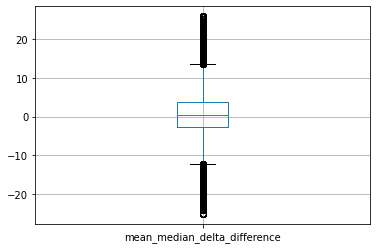

In [69]:
nee['mean_median_delta_difference'].to_frame().boxplot()

In [70]:
print(np.mean(nee[nee.label==1]['mean_median_delta_difference']))
print(np.mean(nee[nee.label==2]['mean_median_delta_difference']))
print(np.mean(nee[nee.label==3]['mean_median_delta_difference']))
print(np.mean(nee[nee.label==4]['mean_median_delta_difference']))

0.6937427667792804
0.7186364805317055
0.17992827098694908
0.5365087221946254


In [71]:
to_join = nee[['session_id','mean_delta_days','mean_median_delta_difference']].drop_duplicates()

In [72]:
to_join.set_index('session_id', inplace=True)

In [73]:
to_join

,mean_delta_days,mean_median_delta_difference
session_id,,
182576,21.966667,17.966667
167384,21.966667,17.966667
102033,21.966667,17.966667
11453,21.966667,17.966667
90303,21.966667,17.966667
...,...,...
1549128,1.000000,0.000000
1590753,3.000000,0.000000
1559831,17.000000,0.000000


In [74]:
# backup = one_hot_df.copy()
# one_hot_df = backup.copy()

In [75]:
one_hot_df = one_hot_df.join(to_join)

In [76]:
one_hot_df

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_6_2_29_Not_applicable_lv3_Not_applicable_lv4,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,other_labels_1,other_labels_2,other_labels_3,other_labels_4,mean_delta_days,mean_median_delta_difference
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.133333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,12.933333,-1.066667
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,50.466667,-12.533333
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.033333,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,19.200000,-0.800000
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.333333,1.333333
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.000000

## Dispersion of categories for each level in each session (Gini index)

In [77]:
one_hot_df['gini_index'] = 1 - (one_hot_df[np.append(relevant_combinations, 'other_combination')].to_numpy()**2).sum(axis=1)

In [78]:
one_hot_df

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,other_labels_1,other_labels_2,other_labels_3,other_labels_4,mean_delta_days,mean_median_delta_difference,gini_index
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.133333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,12.933333,-1.066667,0.877778
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,50.466667,-12.533333,0.906667
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.033333,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,19.200000,-0.800000,0.893333
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.333333,1.333333,0.704444
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.000000,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.

## Customer Segmentation

In [79]:
one_hot_df.head()

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_6_2_35_Not_applicable_lv3_Not_applicable_lv4,1_6_2_54_Not_applicable_lv3_Not_applicable_lv4,1_6_other_lv2_Not_applicable_lv3_Not_applicable_lv4,1_7_2_10_3_1_4_2,1_7_2_22_3_0_4_4,1_7_2_28_3_0_4_4,1_7_2_41_3_0_4_5,1_7_2_45_3_1_4_4,1_7_other_lv2_3_0_4_4,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,other_labels_1,other_labels_2,other_labels_3,other_labels_4,mean_delta_days,mean_median_delta_difference,gini_index
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.133333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,12.933333,-1.066667,0.877778
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,50.466667,-12.533333,0.906667
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.033333,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,19.200000,-0.800000,0.893333
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.333333,1.333333,0.704444
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.000000,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.

In [80]:
customers_1 = one_hot_df['user_identifier'].value_counts().to_frame(name='# of sessions')
customers_2 = one_hot_df[['user_identifier','# of events','days_after_first_event','days_after_last_event','gini_index','weekend','mean_delta_days','mean_median_delta_difference']].groupby(['user_identifier']).mean()

In [81]:
customers_2 = customers_2.rename(columns={
    '# of events': 'avg # of events',
    'days_after_first_event': 'avg_days_after_first_event',
    'days_after_last_event': 'avg_days_after_last_event',
    'gini_index': 'avg_gini_index',
    'mean_delta_days': 'avg_mean_delta_days',
    'mean_median_delta_difference': 'avg_mean_median_delta_difference',
    })

In [82]:
customers = customers_2.join(customers_1)

In [83]:
customers['weekend'] = (customers['weekend']*customers['# of sessions']).apply(lambda x: int(x))

In [84]:
customers

,avg # of events,avg_days_after_first_event,avg_days_after_last_event,avg_gini_index,weekend,avg_mean_delta_days,avg_mean_median_delta_difference,# of sessions
user_identifier,,,,,,,,
0,27.558824,21.941176,2.470588,0.645403,19,13.010408,0.966291,68
1,26.750000,18.066667,2.383333,0.656109,9,13.057301,-1.417699,60
2,26.272727,16.227273,2.295455,0.677131,25,11.452665,-1.013244,44
3,21.615385,16.730769,3.269231,0.633609,19,11.735925,-0.004459,52
4,28.346154,26.884615,2.115385,0.475698,6,12.992392,0.050085,26
...,...,...,...,...,...,...,...,...
871095,1.000000,1.000000,1.000000,0.000000,0,1.000000,0.000000,1
871099,1.000000,3.000000,3.000000,0.000000,0,3.000000,0.000000,1
871110,1.000000,17.000000,17.000000,0.000000,0,17.000000,0.000000,1


In [85]:
std_customers = StandardScaler()
customers_std = std_customers.fit_transform(customers)

In [86]:
pca_customers = PCA()
pca_customers.fit(customers_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained Variance')

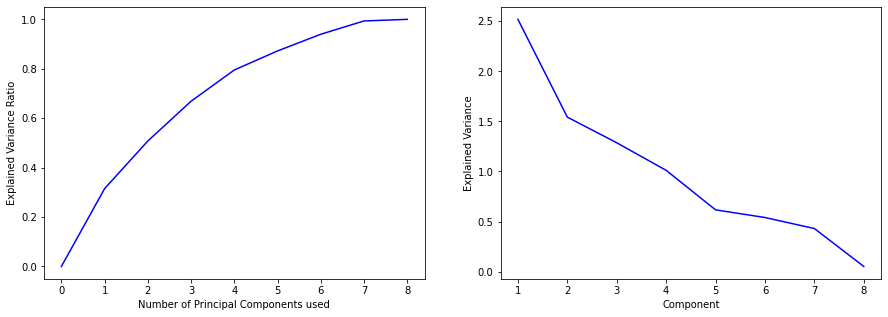

In [87]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
exp_var = np.zeros(len(pca_customers.explained_variance_ratio_)+1)
exp_var[1:] = pca_customers.explained_variance_ratio_
plt.plot(range(len(pca_customers.explained_variance_ratio_)+1), np.cumsum(exp_var), "b-")
plt.xlabel("Number of Principal Components used")
plt.ylabel("Explained Variance Ratio")

plt.subplot(122)
plt.plot(range(1, len(pca_customers.explained_variance_)+1), pca_customers.explained_variance_, "b-")
plt.xlabel("Component")
plt.ylabel("Explained Variance")

In [88]:
pca_customers.explained_variance_ratio_[:6].sum()

0.9397219524691214

In [89]:
pca_customers_6d = PCA(n_components=6)
customers_std_6d = pca_customers_6d.fit_transform(customers_std)

In [90]:
# kmeans_seq = [KMeans(n_clusters=k, random_state=chosen_random_state).fit(customers_std_6d) for k in range(1, 20, 2)]

In [91]:
# silhouette_score_seq = [silhouette_score(customers_std_6d, kmeans.labels_) for kmeans in kmeans_seq[1:]]

In [92]:
# plt.figure(figsize=(10, 10))

# plt.plot(range(3, 20, 2), silhouette_score_seq, "bo-")
# plt.xlabel("$k$", fontsize=15)
# plt.ylabel("Silhouette score", fontsize=15)

The optimal number of clusters is 9.

In [93]:
kmeans_9c = KMeans(n_clusters=9, random_state=chosen_random_state)
kmeans_9c.fit(customers_std_6d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [94]:
kmeans_9c.labels_

array([8, 8, 8, ..., 6, 6, 6], dtype=int32)

In [95]:
pca_customers_2d = PCA(n_components=2)
customers_std_2d = pca_customers_2d.fit_transform(customers_std)

Text(0.5, 1.0, 'Clustered 2D reduced dataset with $k$ = 8')

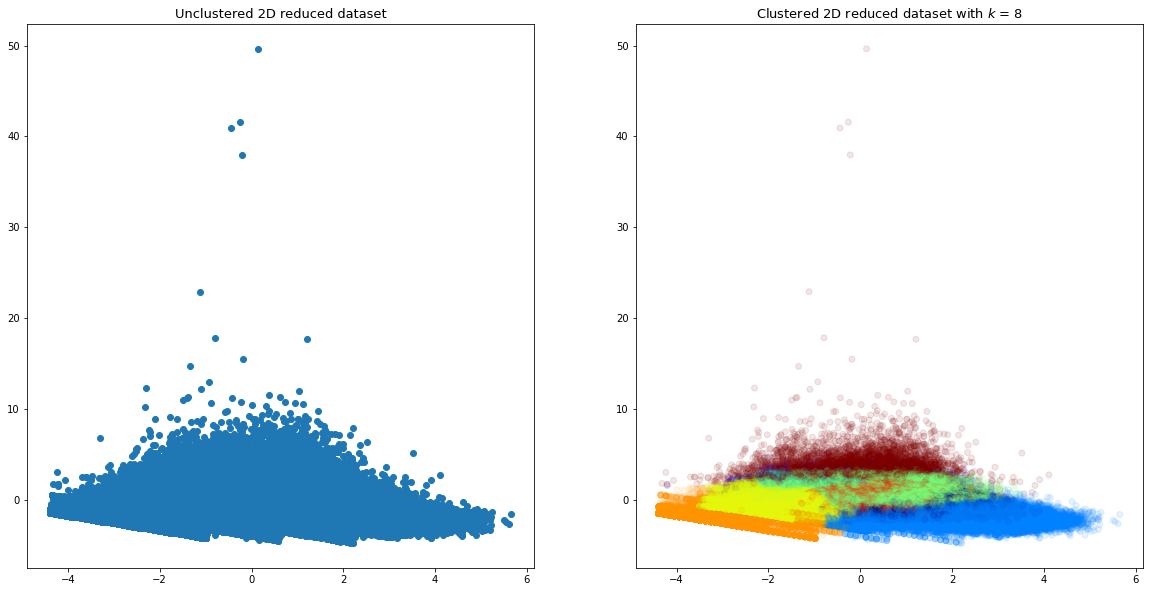

In [96]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(customers_std_2d[:,0], customers_std_2d[:,1])
plt.title("Unclustered 2D reduced dataset", fontsize=13)


plt.subplot(122)
plt.scatter(customers_std_2d[:,0], customers_std_2d[:,1], c=kmeans_9c.labels_, cmap="jet", alpha=0.1)
plt.title("Clustered 2D reduced dataset with $k$ = 8", fontsize=13)

In [97]:
pca_customers_3d = PCA(n_components=3)
customers_std_3d = pca_customers_3d.fit_transform(customers_std)

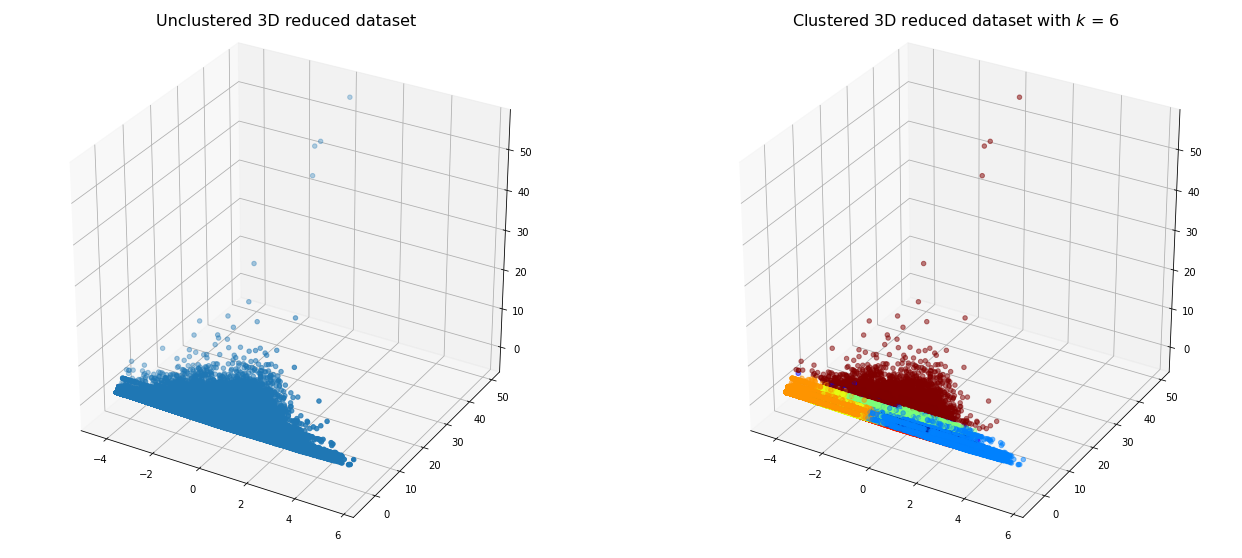

In [98]:
fig = plt.figure(figsize=(22, 10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
p = ax1.scatter(customers_std_3d[:,0], customers_std_3d[:,1], customers_std_3d[:,2])
plt.title("Unclustered 3D reduced dataset", fontsize=16, pad=25)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
p1 = ax2.scatter(customers_std_3d[:,0], customers_std_3d[:,1], customers_std_3d[:,2], c=kmeans_9c.labels_, cmap="jet", alpha=0.5)
plt.title("Clustered 3D reduced dataset with $k$ = 6", fontsize=16, pad=25)

plt.show()

In [99]:
for angle in range(0, 360, 10):
    fig = plt.figure(figsize=(22, 10))
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    p1 = ax2.scatter(customers_std_3d[:,0], customers_std_3d[:,1], customers_std_3d[:,2], c=kmeans_9c.labels_, cmap="jet", alpha=0.5)
    ax2.view_init(30, angle)
    plt.draw()
    plt.pause(.005)

Output hidden; open in https://colab.research.google.com to view.

## Add customer segmentation labels to one_hot_df

In [100]:
customers['customer_cluster_label'] = kmeans_9c.labels_

In [101]:
one_hot_df = one_hot_df.join(customers['customer_cluster_label'], on='user_identifier')

In [102]:
one_hot_df['customer_cluster_label'] = one_hot_df['customer_cluster_label'].apply(lambda x: 'customer_label_'+str(x))

In [103]:
one_hot_df = pd.concat([one_hot_df.drop(columns=['customer_cluster_label']), pd.get_dummies(one_hot_df['customer_cluster_label'])], axis=1)

## Creation submission and train-test split datasets

In [104]:
X = one_hot_df[one_hot_df.label!=0].drop(columns=['user_identifier','tobi_timestamp','label'])
y = one_hot_df[one_hot_df.label!=0]['label']
y_xgboost = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_xgboost = y_train - 1

## Standardization and PCA


In [105]:
one_hot_df

,user_identifier,tobi_timestamp,label,# of events,days_after_first_event,days_after_last_event,1_0_2_20_Not_applicable_lv3_Not_applicable_lv4,1_0_2_2_Not_applicable_lv3_Not_applicable_lv4,1_0_2_3_Not_applicable_lv3_Not_applicable_lv4,1_0_2_4_Not_applicable_lv3_Not_applicable_lv4,1_0_2_7_Not_applicable_lv3_Not_applicable_lv4,1_10_2_30_3_16_Not_applicable_lv4,1_11_2_34_Not_applicable_lv3_Not_applicable_lv4,1_1_2_0_3_0_4_0,1_1_2_0_3_0_4_1,1_1_2_0_3_0_4_3,1_1_2_0_3_1_4_0,1_1_2_0_3_3_4_0,1_1_2_0_3_3_4_2,1_1_2_0_3_3_4_3,1_1_2_10_3_1_4_2,1_2_2_13_3_7_Not_applicable_lv4,1_2_2_13_3_8_Not_applicable_lv4,1_2_2_14_3_2_Not_applicable_lv4,1_2_2_14_3_4_Not_applicable_lv4,1_2_2_1_3_10_Not_applicable_lv4,1_2_2_1_3_11_Not_applicable_lv4,1_2_2_1_3_14_Not_applicable_lv4,1_2_2_1_3_15_Not_applicable_lv4,1_2_2_1_3_2_Not_applicable_lv4,1_2_2_1_3_4_Not_applicable_lv4,1_2_2_1_3_7_Not_applicable_lv4,1_2_2_1_3_8_Not_applicable_lv4,1_2_2_1_other_lv3_Not_applicable_lv4,1_2_2_21_3_14_Not_applicable_lv4,1_2_2_21_3_15_Not_applicable_lv4,1_3_2_11_Not_applicable_lv3_Not_applicable_lv4,1_3_2_15_Not_applicable_lv3_Not_applicable_lv4,1_3_2_16_Not_applicable_lv3_Not_applicable_lv4,1_3_2_31_Not_applicable_lv3_Not_applicable_lv4,...,1_7_other_lv2_3_0_4_5,1_7_other_lv2_3_3_4_4,1_8_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,1_9_Not_applicable_lv2_Not_applicable_lv3_Not_applicable_lv4,other_combination,weekend,week_num_0,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,other_labels_1,other_labels_2,other_labels_3,other_labels_4,mean_delta_days,mean_median_delta_difference,gini_index,customer_label_0,customer_label_1,customer_label_2,customer_label_3,customer_label_4,customer_label_5,customer_label_6,customer_label_7,customer_label_8
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,14976,2020-09-09 18:00:13,1.0,30,16,3,0.0,0.133333,0.133333,0.1,0.200000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.033333,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,12.933333,-1.066667,0.877778,0,0,0,1,0,0,0,0,0
23,22166,2020-09-08 18:46:02,0.0,30,64,26,0.0,0.100000,0.100000,0.2,0.100000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.033333,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,50.466667,-12.533333,0.906667,0,0,1,0,0,0,0,0,0
27,26655,2020-07-20 11:34:02,0.0,30,42,1,0.0,0.133333,0.033333,0.1,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,19.200000,-0.800000,0.893333,0,1,0,0,0,0,0,0,0
30,39859,2020-08-01 20:45:21,0.0,30,8,2,0.0,0.066667,0.400000,0.3,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.333333,1.333333,0.704444,0,0,0,1,0,0,0,0,0
32,1716,2020-07-22 16:54:03,4.0,30,25,1,0.0,0.100000,0.466667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,14.600000,-0.400000,0.746667,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [106]:
std = StandardScaler()
X_std = std.fit_transform(X)

In [107]:
std_split = StandardScaler()
X_train_std = std_split.fit_transform(X)

In [108]:
pca_09 = PCA(n_components=0.9)
X_std_09 = pca_09.fit_transform(X_std)

In [109]:
pca_split_09 = PCA(n_components=0.9)
X_train_std_09 = pca_split_09.fit_transform(X_train_std)

## Gradient boosting

### Train-test split

In [110]:
param_grid = {
    'max_depth': [12, 10, 8, 6],
    'max_features': ['sqrt', None],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 200, 100]
}

In [111]:
gradient_boosting_clf = GradientBoostingClassifier()

In [112]:
grid_search = GridSearchCV(estimator = gradient_boosting_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 5)

#### Fitting dataset without standardization and PCA

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=10, random_state=chosen_random_state)

gradient_boosting_clf.fit(X_train, y_train)

prediction = gradient_boosting_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(prediction, y_test)
conf_matrix = confusion_matrix(prediction, y_test)
print(accuracy)
print(conf_matrix)

In [ ]:
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for learning_rate in param_grid['learning_rate']:
      for n_estimators in param_grid['n_estimators']:
        print('Parameters: max_depth = '+str(max_depth)+' max_features = '+str(max_features)+' learning_rate = '+str(learning_rate)+' n_estimators = '+str(n_estimators))
        gradient_boosting_clf = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, max_features = max_features, min_samples_leaf=5, min_samples_split=10, random_state=chosen_random_state)
        gradient_boosting_clf.fit(X_train, y_train)
        prediction = gradient_boosting_clf.predict(X_test)
        accuracy = accuracy_score(prediction, y_test)
        print(accuracy)

#### Fitting dataset with standardization and PCA

In [ ]:
grid_search.fit(X_train_std_09, y)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier(n_estimators = 200, random_state=chosen_random_state)

gradient_boosting_clf.fit(X_train_std_09, y)

prediction = gradient_boosting_clf.predict(pca_split_09.transform(std_split.transform(X_test)))

In [ ]:
accuracy = accuracy_score(prediction, y_test)
conf_matrix = confusion_matrix(prediction, y_test)
print(accuracy)
print(conf_matrix)

In [ ]:
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for learning_rate in param_grid['learning_rate']:
      for n_estimators in param_grid['n_estimators']:
        print('Parameters: max_depth = '+str(max_depth)+' max_features = '+str(max_features)+' learning_rate = '+str(learning_rate)+' n_estimators = '+str(n_estimators))
        gradient_boosting_clf = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, max_features = max_features, min_samples_leaf=5, min_samples_split=10, random_state=chosen_random_state)
        gradient_boosting_clf.fit(X_train_std_09, y_train)
        prediction = gradient_boosting_clf.predict(pca_split_09.transform(std_split.transform(X_test)))
        accuracy = accuracy_score(prediction, y_test)
        print(accuracy)

### Submission

In [ ]:
param_grid = {
    'max_depth': [12, 10, 8, 6],
    'max_features': ['sqrt', None],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 200, 100]
}

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier()

In [ ]:
grid_search = GridSearchCV(estimator = random_forest_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3)

#### Fitting dataset without standardization and PCA

In [ ]:
grid_search.fit(X, y)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier(n_estimators = 200, random_state=chosen_random_state)

gradient_boosting_clf.fit(X, y)

df_predict = one_hot_df[one_hot_df.label==0].drop(columns=['user_identifier','tobi_timestamp','label'])
prediction = gradient_boosting_clf.predict(df_predict)

df_predict['predicted_values'] = prediction
test = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')
test.set_index('session_id')
test = test.join(df_predict['predicted_values'], on='session_id')

#### Fitting dataset with standardization and PCA

In [ ]:
grid_search.fit(X_std_35d, y)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier(n_estimators = 200, random_state=chosen_random_state)

gradient_boosting_clf.fit(X_std_09, y)

df_predict = one_hot_df[one_hot_df.label==0]
df_predict_std_09 = pca_09.transform(std.transform(one_hot_df[one_hot_df.label==0].drop(columns=['user_identifier','tobi_timestamp','label'])))
prediction = gradient_boosting_clf.predict(df_predict_std_09)

df_predict['predicted_values'] = prediction
test = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')
test.set_index('session_id')
test = test.join(df_predict['predicted_values'], on='session_id')

#### Submission file

In [ ]:
test['predicted_values'] = test['predicted_values'].apply(lambda x: int(x))

In [ ]:
test['predicted_values'].to_csv('submission_gradient_boosting.txt',index=False, header=False)

## Neural network

In [ ]:
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y_submission = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_submission = np_utils.to_categorical(encoded_y_submission)

In [ ]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(units=64, input_dim=X_std_09.shape[1], activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(units=32, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(units=16, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(units=8, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(units=4, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
weights = {1:(len(one_hot_df[one_hot_df.label==1])/len(one_hot_df[one_hot_df.label!=0]))**(-1),
           2:(len(one_hot_df[one_hot_df.label==2])/len(one_hot_df[one_hot_df.label!=0]))**(-1),
           3:(len(one_hot_df[one_hot_df.label==3])/len(one_hot_df[one_hot_df.label!=0]))**(-1),
           4:(len(one_hot_df[one_hot_df.label==4])/len(one_hot_df[one_hot_df.label!=0]))**(-1)}

In [ ]:
print(weights)

In [ ]:
weights_up = {0:3.5, 1:2.5, 2:4, 3:4}

### Train-test split

In [ ]:
model.fit(X_train_std_09, dummy_y_submission, batch_size = 100, epochs=300, shuffle=False, class_weight=weights_up)

In [ ]:
prediction = gradient_boosting_clf.predict(pca_split_09.transform(std_split.transform(X_test)))

In [ ]:
accuracy = accuracy_score(prediction, y_test)
conf_matrix = confusion_matrix(prediction, y_test)
print(accuracy)
print(conf_matrix)

### Submission

In [ ]:
model.fit(X_std_09, dummy_y_submission, batch_size = 32, epochs=25, shuffle=False, class_weight=weights_up)

In [ ]:
df_predict = one_hot_df[one_hot_df.label==0]
df_predict_std_09 = pca_09.transform(std.transform(one_hot_df[one_hot_df.label==0].drop(columns=['user_identifier','tobi_timestamp','label'])))
y_scores = model.predict(df_predict_std_09)
scores = pd.DataFrame(y_scores).rename(columns={0:1,1:2,2:3,3:4})
prediction = scores.idxmax(axis=1).to_numpy()

df_predict['predicted_values'] = prediction
test = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')
test.set_index('session_id')
test = test.join(df_predict['predicted_values'], on='session_id')

In [ ]:
test['predicted_values'] = test['predicted_values'].apply(lambda x: int(x))

In [ ]:
test['predicted_values'].to_csv('/content/drive/My Drive/Vodafone Hackaton/submission_neural_network.txt',index=False, header=False)

## XGBoost

### Train-test split

In [ ]:
param_grid = {
    'max_depth': [12, 10, 8, 6],
    'max_features': ['sqrt', None],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 200, 100]
}

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate, 
                             max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=2)

In [ ]:
grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 5)

#### Fitting dataset without standardization and PCA

In [ ]:
grid_search.fit(X_train, y_train_xgboost)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=150, tree_method='gpu_hist', eta=1.0, 
                             max_depth=8, colsample_bytree=0.8, random_state=chosen_random_state, verbosity=3)

xgb_model.fit(X_train, y_train_xgboost)

prediction = xgb_model.predict(X_test)
prediction = prediction.argmax(axis=1)+1

In [ ]:
accuracy = accuracy_score(prediction, y_test)
conf_matrix = confusion_matrix(prediction, y_test)
print(accuracy)
print(conf_matrix)

In [ ]:
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for learning_rate in param_grid['learning_rate']:
      for n_estimators in param_grid['n_estimators']:
        print('Parameters: max_depth = '+str(max_depth)+' max_features = '+str(max_features)+' learning_rate = '+str(learning_rate)+' n_estimators = '+str(n_estimators))
        xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate, 
                             max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=2)
        xgb_model.fit(X_train, y_train_xgboost)
        prediction = xgb_model.predict(X_test)
        prediction = prediction.argmax(axis=1)+1
        accuracy = accuracy_score(prediction, y_test)
        print(accuracy)

#### Fitting dataset with standardization and PCA

In [ ]:
grid_search.fit(X_train_std_09, y_train_xgboost)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate, 
                             max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=2)

xgb_model.fit(X_train_std_09, y_train_xgboost)

prediction = xgb_model.predict(pca_split_09.transform(std_split.transform(X_test)))
prediction = prediction.argmax(axis=1)+1

In [ ]:
accuracy = accuracy_score(prediction, y_test)
conf_matrix = confusion_matrix(prediction, y_test)
print(accuracy)
print(conf_matrix)

In [ ]:
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for learning_rate in param_grid['learning_rate']:
      for n_estimators in param_grid['n_estimators']:
        print('Parameters: max_depth = '+str(max_depth)+' max_features = '+str(max_features)+' learning_rate = '+str(learning_rate)+' n_estimators = '+str(n_estimators))
        xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate, 
                             max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=2)
        xgb_model.fit(X_train_std_09, y_train_xgboost)
        prediction = xgb_model.predict(pca_split_09.transform(std_split.transform(X_test)))
        prediction = prediction.argmax(axis=1)+1
        accuracy = accuracy_score(prediction, y_test)
        print(accuracy)

### Submission

In [ ]:
param_grid = {
    'max_depth': [12, 10, 8, 6],
    'max_features': ['sqrt', None],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 200, 100]
}

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate, 
                             max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=2)

In [ ]:
grid_search = GridSearchCV(estimator = random_forest_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3)

#### Fitting dataset without standardization and PCA

In [ ]:
grid_search.fit(X, y_xgboost)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=120, tree_method='gpu_hist', eta=1.0, 
                             max_depth=8, colsample_bytree=0.8, random_state=chosen_random_state, verbosity=2)

xgb_model.fit(X, y_xgboost)

df_predict = one_hot_df[one_hot_df.label==0].drop(columns=['user_identifier','tobi_timestamp','label'])
prediction = xgb_model.predict(df_predict)
prediction = prediction.argmax(axis=1)+1

df_predict['predicted_values'] = prediction
test = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')
test.set_index('session_id')
test = test.join(df_predict['predicted_values'], on='session_id')

#### Fitting dataset with standardization and PCA

In [ ]:
grid_search.fit(X_std_35d, y_xgboost)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_params_

In [ ]:
xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=125, tree_method='gpu_hist', eta=1.0, 
                             max_depth=8, colsample_bytree=0.7, random_state=chosen_random_state, verbosity=2)

xgb_model.fit(X_std_09, y_xgboost)

df_predict = one_hot_df[one_hot_df.label==0]
df_predict_std_09 = pca_09.transform(std.transform(one_hot_df[one_hot_df.label==0].drop(columns=['user_identifier','tobi_timestamp','label'])))
prediction = xgb_model.predict(df_predict_std_09)
prediction = prediction.argmax(axis=1)+1

df_predict['predicted_values'] = prediction
test = pd.read_csv('/content/drive/My Drive/Vodafone Hackaton/test.csv')
test.set_index('session_id')
test = test.join(df_predict['predicted_values'], on='session_id')

#### Submission file

In [ ]:
test['predicted_values'] = test['predicted_values'].apply(lambda x: int(x))

In [ ]:
test['predicted_values'].to_csv('submission_gradient_boosting.txt',index=False, header=False)

## Cross-validation

In [ ]:
param_grid = {
    'max_depth': [10, 8, 6],
    'max_features': [1, 0.7, 0.8],
    'learning_rate': [0.1, 0.5, 1.0],
    'n_estimators': [150, 200, 250]
}

In [ ]:
results = {}
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for learning_rate in param_grid['learning_rate']:
      for n_estimators in param_grid['n_estimators']:
        combo = 'Parameters: max_depth = '+str(max_depth)+' max_features = '+str(max_features)+' learning_rate = '+str(learning_rate)+' n_estimators = '+str(n_estimators)
        print(combo)
        xgb_model = xgb.XGBRegressor(objective="multi:softprob", num_class=4, n_estimators=n_estimators, tree_method='gpu_hist', eta=learning_rate,
                                      max_depth=max_depth, colsample_bytree=max_features, random_state=chosen_random_state, verbosity=1)
        scores = 0
        for i in range(3):
          X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.2)
          y_train_cv_xgboost = y_train_cv-1
          xgb_model.fit(X_train_cv, y_train_cv_xgboost)
          prediction = xgb_model.predict(X_test_cv)
          prediction = prediction.argmax(axis=1)+1
          accuracy = accuracy_score(prediction, y_test_cv)
          scores += accuracy
        print(scores/3)
        results[combo] = scores/3